In [41]:
!pip install flash-attn --no-build-isolation
!pip install bitsandbytes
!pip uninstall peft && pip install -U peft
!pip install torchviz -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found existing installation: peft 0.12.0
Uninstalling peft-0.12.0:
  Would remove:
    /home/vishwa/Enter/lib/python3.9/site-packages/peft-0.12.0.dist-info/*
    /home/vishwa/Enter/lib/python3.9/site-packages/peft/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [1]:
# moon dream 2
import torch
torch.cuda.empty_cache()
from peft import LoraConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

DEVICE = "cuda"
DTYPE = torch.float32 if DEVICE == "cpu" else torch.float16 # CPU doesn't support float16
MD_REVISION = "2024-07-23"

tokenizer = AutoTokenizer.from_pretrained("vikhyatk/moondream2", revision=MD_REVISION)

USE_LORA = True
USE_QLORA = True

if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules='.*(text_model|vision_encoder).*(out_proj|Wqkv|fc1|fc2|qkv).*$',
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

    moondream = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2", revision=MD_REVISION, trust_remote_code=True, 
    attn_implementation="flash_attention_2" if DEVICE == "cuda" else None,
    torch_dtype=torch.float16, device_map={"": DEVICE}
)
    
    # moondream.enable_input_requires_grad()
    # moondream.add_adapter(lora_config)
    # moondream.enable_adapters()

    from peft import get_peft_model

moondream = get_peft_model(moondream, lora_config)
moondream.print_trainable_parameters()

trainable params: 9,809,664 || all params: 1,876,729,456 || trainable%: 0.5227


In [2]:
t = torch.load('/home/vishwa/amzn-ml/final.pth')
moondream.load_state_dict(t)
moondream.eval()

PeftModel(
  (base_model): LoraModel(
    (model): Moondream(
      (vision_encoder): VisionEncoder(
        (encoder): EncoderWrapper(
          (model): ModuleDict(
            (visual): VisionTransformer(
              (patch_embed): LinearPatchEmbedding(
                (linear): Linear(in_features=588, out_features=1152, bias=True)
              )
              (blocks): Sequential(
                (0): VitBlock(
                  (attn): Attention(
                    (qkv): lora.Linear(
                      (base_layer): Linear(in_features=1152, out_features=3456, bias=True)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.1, inplace=False)
                      )
                      (lora_A): ModuleDict(
                        (default): Linear(in_features=1152, out_features=8, bias=False)
                      )
                      (lora_B): ModuleDict(
                        (default): Linear(in_features=8, out_features=3

In [3]:
import pandas as pd
# loading dataset
train_df = pd.read_csv("/home/vishwa/amzn-ml/student_resource 3/dataset/train.csv")
test_df = pd.read_csv('/home/vishwa/amzn-ml/student_resource 3/dataset/test.csv')

In [4]:
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'maximum_weight_recommendation': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre',
        'cubic foot',
        'cubic inch',
        'cup',
        'decilitre',
        'fluid ounce',
        'gallon',
        'imperial gallon',
        'litre',
        'microlitre',
        'millilitre',
        'pint',
        'quart'}
}

allowed_units = {unit for entity in entity_unit_map for unit in entity_unit_map[entity]}

In [5]:
from PIL import Image


In [6]:
from torch.utils.data import Dataset
# from datasets import load_dataset

class AmazonDataset(Dataset):
    def __init__(self, train_df):
        self.data = train_df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # print(idx)
        sample = self.data.loc[idx, :]
        # print(sample)
        return {
            "image": Image.open('/home/vishwa/amzn-ml/student_resource 3/train_images/' + sample['image_link'].split('/')[-1]), # Should be a PIL image
            "qa": [
                {
                    "question": f"Extract the {sample['entity_name']} from the text and only use these units: {entity_unit_map[sample['entity_name']]}",
                    "answer": sample["entity_value"],
                }
            ]
        }

datasets = {
    "train": AmazonDataset(train_df),
    "test": AmazonDataset(test_df),
}

In [7]:
next(iter(datasets['train']))

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1600x1600>,
 'qa': [{'question': "Extract the item_weight from the text and only use these units: {'milligram', 'gram', 'kilogram', 'microgram', 'pound', 'ton', 'ounce'}",
   'answer': '500.0 gram'}]}

In [8]:
volume_df = train_df[train_df['entity_name'] == 'item_volume']

In [9]:
volume_df[:5]

,image_link,group_id,entity_name,entity_value
1,https://m.media-amazon.com/images/I/71gSRbyXmo...,916768,item_volume,1.0 cup
21,https://m.media-amazon.com/images/I/61wzlucTRE...,252585,item_volume,4.0 gallon
49,https://m.media-amazon.com/images/I/61AHQ35poH...,884560,item_volume,10.0 ounce
63,https://m.media-amazon.com/images/I/61-oj+N+Bx...,459516,item_volume,30.0 millilitre
64,https://m.media-amazon.com/images/I/71e6kJLE+L...,459516,item_volume,30.0 millilitre


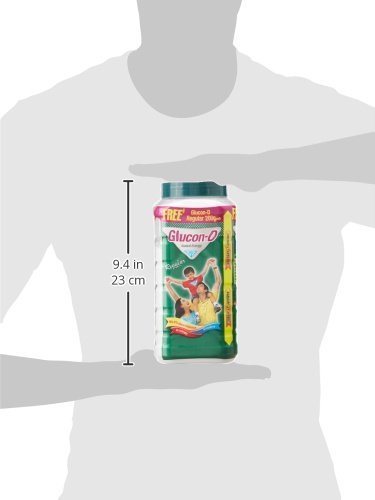

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7F69B3CF36A0>
Question Extract the item_weight from the text and only use these units: {'milligram', 'gram', 'kilogram', 'microgram', 'pound', 'ton', 'ounce'}
Answer 200 gram
Moondream: 50 gram


In [16]:
for i in range(20,21):
    sample = datasets['train'][i]
    display(sample['image'])
    print(sample['image'])

    for qa in sample['qa']:
        print("Question", qa['question'])
        print("Answer", qa['answer'])
        # print(moondream.vision_encoder.preprocess(sample['image']).shape)

        preprocessed_image = moondream.vision_encoder.preprocess(sample['image'])
        print("Moondream:", moondream.answer_question(moondream.encode_image(preprocessed_image.reshape(1, preprocessed_image.shape[0],preprocessed_image.shape[1], preprocessed_image.shape[2])),
        qa['question'],
        tokenizer = tokenizer)
    )

In [24]:
from tqdm import tqdm
horizontal = []
vertical = []
for i in tqdm(range(len(train_df))):
    try:
        image = Image.open('/home/vishwa/amzn-ml/student_resource 3/train_images/' + train_df['image_link'][i].split('/')[-1])
        horizontal.append(image.size[0])
        vertical.append(image.size[1])
    except:
        pass
# print(horizontal, vertical)

100%|██████████| 263859/263859 [00:50<00:00, 5196.07it/s] 


In [36]:
horizontal_t = [t for t in horizontal if t < 1000]

In [43]:
print(len(horizontal_t))

14627


{'whiskers': [<matplotlib.lines.Line2D at 0x7f69a9165f70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f69a8d5f730>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f69a8d69700>],
 'medians': [<matplotlib.lines.Line2D at 0x7f693bdd6e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f693bdd6400>],
 'means': []}

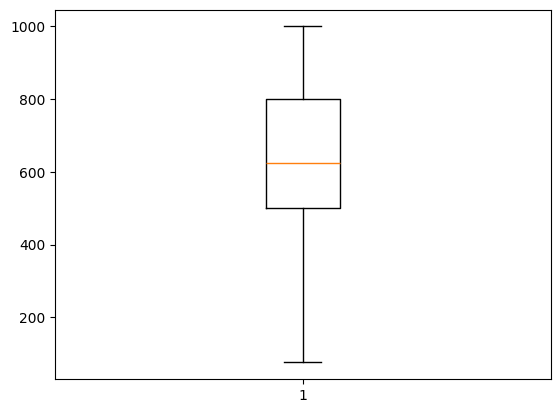

In [38]:
import matplotlib.pyplot as plt 
import numpy as np
plt.boxplot(sorted(horizontal_t))
# mean_value = np.mean(horizontal_t)
# print(f"Mean: {mean_value}")

# # Calculate and print median
# median_value = np.median(horizontal_t)
# print(f"Median: {median_value}")

# print("Min: ",min(horizontal_t))

In [39]:
vertical_t = [t for t in vertical if t < 1000]

In [44]:
print(len(vertical_t))

18255


Mean: 670.3415502602027
Median: 694.0


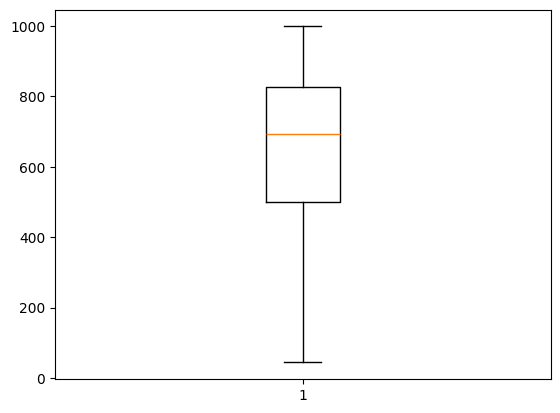

In [42]:
plt.boxplot(sorted(vertical_t))
mean_value = np.mean(vertical_t)
print(f"Mean: {mean_value}")

# Calculate and print median
median_value = np.median(vertical_t)
print(f"Median: {median_value}")


In [57]:
from tqdm import tqdm
horizontal = 3000
horizontal_id = None
vertical = 3000
vertical_id = None
for i in tqdm(range(len(train_df))):
    try:
        image = Image.open('/home/vishwa/amzn-ml/student_resource 3/train_images/' + train_df['image_link'][i].split('/')[-1])
        if (image.size[0] < horizontal):
            horizontal = image.size[0]
            horizontal_id = train_df['image_link'][i].split('/')[-1]

        if (image.size[1] < vertical):
            vertical = image.size[1]
            vertical_id = train_df['image_link'][i].split('/')[-1]
    except:
        pass
# print(horizontal, vertical)

100%|██████████| 263859/263859 [00:19<00:00, 13598.21it/s]


In [58]:
print(horizontal, horizontal_id)
print(vertical, vertical_id)

76 21gLl3e-kzL.jpg
44 21sATesgJrL.jpg


(76, 204)


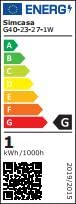

In [61]:
image = Image.open('/home/vishwa/amzn-ml/student_resource 3/train_images/' + horizontal_id)
print(image.size)
display(image)

(500, 44)


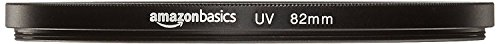

In [63]:
image = Image.open('/home/vishwa/amzn-ml/student_resource 3/train_images/' + vertical_id)
print(image.size)
display(image)